# Import the packages

In [139]:
import numpy as np
from math import sqrt
import skimage.io as io
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian
from skimage import transform
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage
from skimage.measure import ransac
import pandas as pd
from sklearn.linear_model import RANSACRegressor
import pandas as pd
from scipy import spatial
import scipy.misc as sp
from skimage.filters import gaussian
from PIL import Image
from sklearn.metrics import mean_squared_error
from cmath import inf
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from matplotlib import axes
from matplotlib import figure
import Polywarp

# Scales in um/pixel for smFRET and sequencing imaging
scale_sm = 0.204 
scale_seq = 0.34

plt.rcParams["figure.dpi"] = 300

# All the function needed

In [120]:
def residual_cal(src, dst):
    """This function is used to calculate the residual between src and dst.

    Args:
        src (numpy array): The source array having (N, 2) shape with N points.
        dst (numpy array): The destination array having (N, 2) shape with N points.

    Returns:
        mse: The mean squared error between these two arraies.
    """
    mse = mean_squared_error(src, dst)
    return mse


def blob_detection(img, min_sigma, max_sigma, threshold, method=0):
    """This function is mostly used for detecting the beads in any image.

    Args:
        img_path (string): The absolute path of the input image.
        min_sigma (int): The minimum sigma, lower it is, smaller the blob will be detected.
        max_sigma (int): The maximum sigma, higher it is, bigger the blob will be detected.
        threshold (float): Higher it is, higher the intensities of blobs.
        method (int, optional): 0 for Difference of Gaussian (DoG) and 1 for Determinant of Hessian (DoH). 
        They should be applied with different combination of parameters. DoG is more suitable for fret movies,
        while DoH is more suitable for sequencing images. Defaults to 0.

    Returns:
        centers: A numpy array containing the coordinates of all the centers.
    """
    #img = io.imread(img_path)
    if method == 0:
        blob = blob_dog(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    else:
        blob = blob_doh(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    i = 0
    # r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(centers[i], [x - r, y - r]))
            i += 1
    return np.array(centers)


""" 
    Wrapped polynomial transformation for Ransac using.
"""
# class QuadPolyTrans(transform.PolynomialTransform):
#     def estimate(*data):
#         return transform.PolynomialTransform.estimate(*data, order=2)


# class CubicPolyTrans(transform.PolynomialTransform):
#     def estimate(*data):
#         return transform.PolynomialTransform.estimate(*data, order=3)


def count_nearest_pts(src, dst, radius):
    """Counting the number of nearest neighbors for each given point.

    Args:
        src (numpy array): (N, 2) shape array. Build the kd tree based on this.
        dst (numpy array): (N, 2) shape array. For each point in this array, find the nearest neighbors in src array.
        radius (int): The maximum searching radius.

    Returns:
        res, idx: res is the distance for the point and its neighbor, 'inf' means no neighbor in given search radius. 
        idx is the index for the neighbor in src array.
    """
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    for i in range(0, len(idx)):
        if len(np.argwhere(idx == idx[i])) > 1:
            res[i] = inf
    return res, idx


def save_np_img(npimg, path):
    """Sava a numpy array as an image.

    Args:
        npimg (numpy array): A numpy array need to be saved as image.
        path (string): The save path.
    """
    img = Image.fromarray(npimg)
    img = img.convert("L")
    img.save(path, dpi=(300.0, 300.0))


def plotting_res(canvas_size, res, pts_radius, save_path, gaussian_sigma=3):
    """ This function is used to generate any given numpy array to the image.

    Args:
        canvas_size (tuple): A two-element tuple as (x_range, y_range). Determine the size of generated image.
        res (numpy array): The point set needed to generate the image.
        pts_radius (int): The radius of the points.
        save_path (string): The save path of the generated image.
        gaussian_sigma (int, optional): The radius of gaussian blurring. Defaults to 3.
    """
    x_range, y_range = canvas_size
    pk_img = np.zeros(canvas_size)
    for ele in res:
        y = int(ele[0])
        x = int(ele[1])
        for j in range(0, pts_radius):
            for k in range(0, pts_radius):
                pk_img[
                    min(max(0, x - j), x_range - 1), min(max(0, y - k), y_range - 1)
                ] = (1024 * 2)
                pk_img[
                    min(x_range - 1, max(0, x + j)), min(max(0, y - k), y_range - 1)
                ] = (1024 * 2)
                pk_img[
                    min(x_range - 1, max(0, x + j)), min(y_range - 1, max(0, y + k))
                ] = (1024 * 2)
                pk_img[
                    min(max(0, x - j), x_range - 1), min(y_range - 1, max(0, y + k))
                ] = (1024 * 2)
    blurred_img = gaussian(pk_img, sigma=gaussian_sigma, multichannel=False)
    save_np_img(blurred_img, save_path)


def count_pairs(ref_coord, target_coord, radius):
    """This function is used for counting how many pairs are there exsist in two point sets.

    Args:
        ref_coord (numpy array): The source point set.
        target_coord (numpy array): The target point set.
        radius (int): Searching radius.

    Returns:
       pairs: (int) The number of pairs.
    """
    tree = spatial.KDTree(ref_coord)
    res, idx = tree.query(target_coord, k=1)
    polished_fretPts = ref_coord[idx[np.where(res != inf)]]
    pairs = 0
    pp = 0
    for i in idx:
        if res[pp] < radius:
            pairs += 1
        pp += 1
    return pairs


def read_coord(csv_path):
    """Read csv file and transfer them into numpy array.

    Args:
        csv_path (string): CSV file path.

    Returns:
        pts: The numpy array containing all the coordinats in the given csv file.
    """
    res_tb = pd.read_csv(csv_path)
    pts = np.column_stack(
        (np.array(res_tb["X"][0 : len(res_tb)]), np.array(res_tb["Y"][0 : len(res_tb)]))
    )
    return pts


def show_blob_detection_res(img, min_sigma, max_sigma, threshold, method=0):
    """
    Showing the result of 'blob detection' function. Used as the same way of 'blob_detection'
    """
    fig, ax = plt.subplots()
    #img = io.imread(img_path)
    ax.imshow(img)
    if method == 0:
        res = blob_dog(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    else:
        res = blob_doh(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    i = 0
    CM = []
    r = 3
    [h, w] = img.shape
    for blob in res:
        y, x, r = blob
        # print(r)
        if y > r and y < (h - r) and x > r and x < (w - r):
            CM.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r), int(x - r) : int(x + r)]
                )
            )
            CM[i] = list(np.add(CM[i], [y - r, x - r]))
            x1, y1 = CM[i]
            c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
            i += 1
    ax.set_axis_off()
    plt.show()


# Implement the Alignment
#### Using mannually labelled beads as the first rough alignment

> $res\_tb$ is the clicked results from ImageJ

In [121]:
root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()

# N beads measured first in smFRET and then in the sequencing image (min projection)
# Beads image red channel [256:,:] first
# All done manually in imageJ with Measurement/Center of mass and saved as a .csv
man_beads_path = filedialog.askopenfilename(title = "Choose the .csv file with manual bead coordinates", initialdir = "C:/Users/Anton/Documents/Jupyter home/MUSCLE/ExampleData/Test/")

res_tb = pd.read_csv(man_beads_path)
sample_num = int(len(res_tb) / 2)
src = np.column_stack(
    (np.array(res_tb["XM"][0:sample_num]), np.array(res_tb["YM"][0:sample_num]))
)
dst = np.column_stack(
    (np.array(res_tb["XM"][sample_num:]), np.array(res_tb["YM"][sample_num:]))
)

rough_tf = transform.estimate_transform("similarity", src=src, dst=dst)
rough_tf_inv = transform.estimate_transform("similarity", src=dst, dst=src)
# rough_tf.params[0,2]=rough_tf.params[1,2]=rough_tf_inv.params[0,2]=rough_tf_inv.params[1,2]=0
rough_tf.params[0:2,0:3] = rough_tf.params[0:2,0:3]*0.1
rough_tf_inv.params[0:2,0:3] = rough_tf_inv.params[0:2,0:3]*10


In [130]:
print(rough_tf.params)

[[ 5.97938194e-01  1.31603088e-03  1.70104682e+01]
 [-1.31603088e-03  5.97938194e-01  1.39726009e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Applying the rough transformation to the smFRET bead image to facilitate cross-correlation registration (skip by default)

In [174]:
from skimage.util import img_as_uint, img_as_ubyte
import skimage as si
root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()
smFRET_beads = filedialog.askopenfilename(title = "Choose the smFRET beads file to transform", initialdir = "D:/Experiments/MUSCLE DONUTS/Cas9_CCR5/beads_op")
img1 = io.imread(smFRET_beads)
img1 = img1[:,256:,:]
img1 = np.mean(img1, axis = 0) #averaging by the stack
img1 = img1.astype("ushort") #turn from float format to ushort
img1 = img1 - si.restoration.rolling_ball(img1, radius=10)
# print(rough_tf.params)
shp = np.zeros([1,2])
shp[0,:] = img1.shape
shape1 = np.absolute(rough_tf1(shp)).astype(int)
# img2 = transform.warp(img1, rough_tf_inv,output_shape = shape1.tolist()[0])
img2 = transform.warp(img1, rough_tf_inv1,output_shape = shape1.tolist()[0])
io.imsave(smFRET_beads[:-4]+'_tf.tif',img_as_ubyte(img2))

C:\Users\Anton\AppData\Local\Temp\ipykernel_3992\497057174.py:18: UserWarning: D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/red/Pos243._tf.tif is a low contrast image
  io.imsave(smFRET_beads[:-4]+'_tf.tif',img_as_ubyte(img2))


#### Getting centers of automatically labelled beads (using center of mass)

The parameters could be adjust:

 1. $min\_sigma$ determine how small the blobs could be detected
 2. $max\_sigma$ determine how big the blobs could be detected
 3. $threhold$ determine the intensities of blobs.


> Uncomment $show\_blob\_detection\_res$ to show the result. It could also be used before getting the final result.

Open the smFRET bead image and prepare it for bead mapping

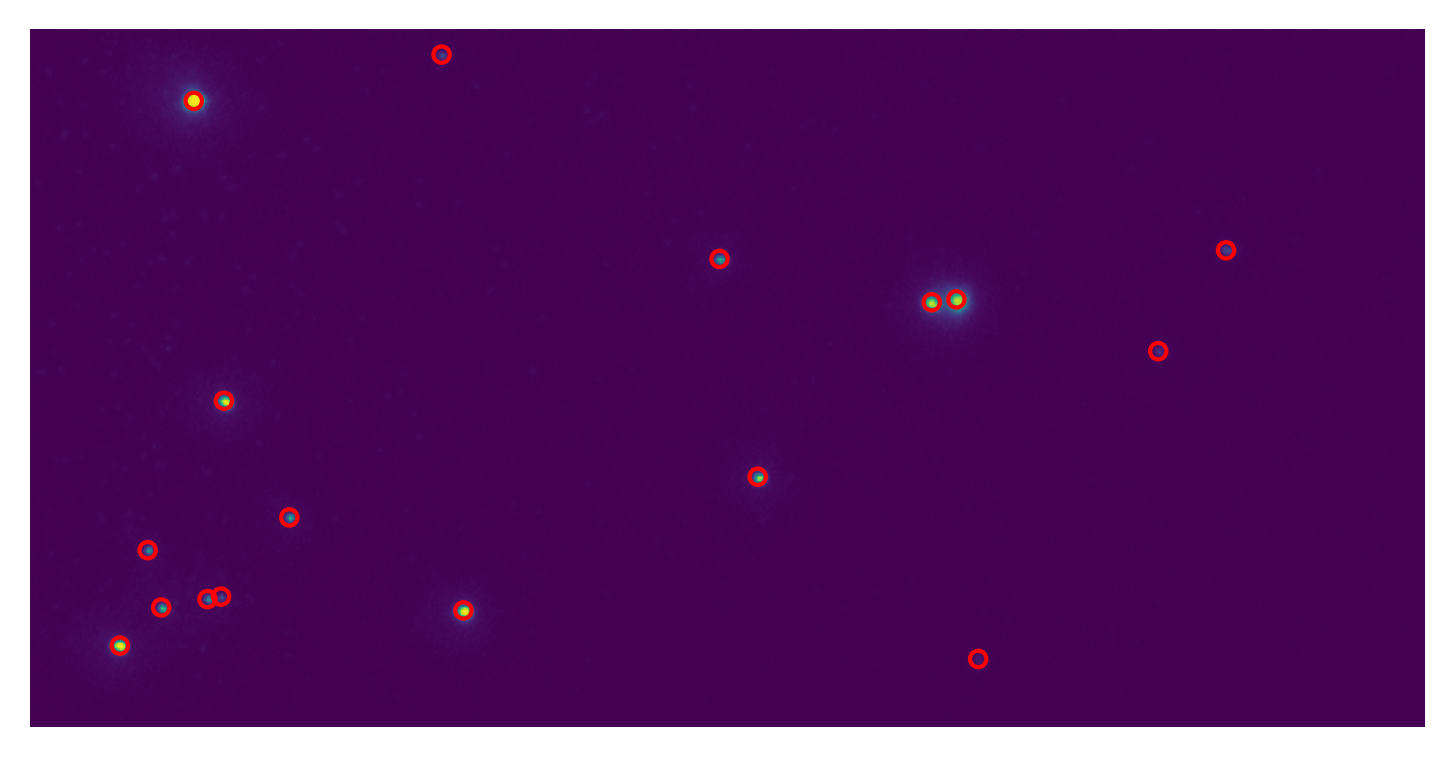

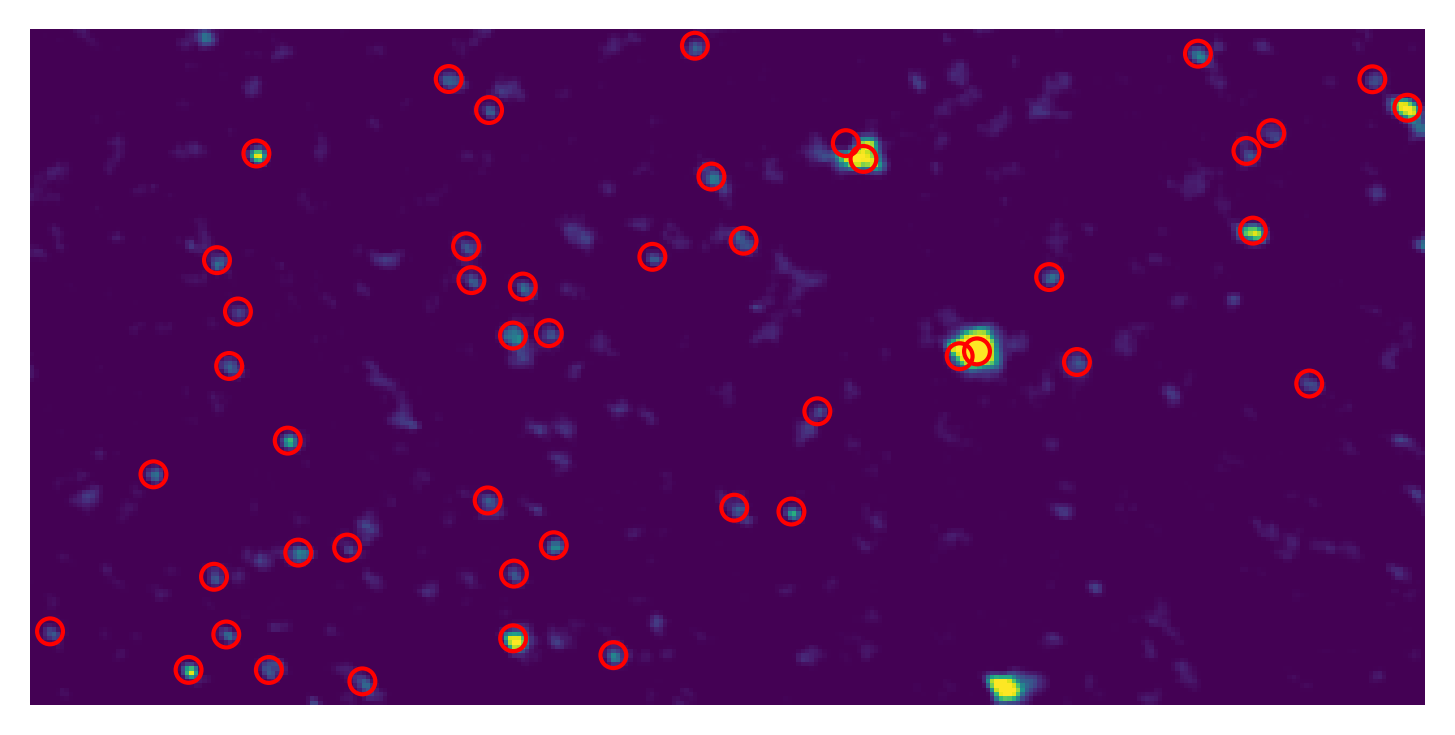

In [125]:
rb_rad = 10
path_smbeads = filedialog.askopenfilename(title = "Choose the smFRET bead movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")
img_beads_sm = io.imread(path_smbeads)
if len(img_beads_sm.shape) == 3:
    img_beads_sm = np.mean(img_beads_sm, axis = 0)
    img_beads_sm = img_beads_sm.astype("ushort")
rbrad = 10
img_beads_sm = img_beads_sm[256:,:]
img_beads_sm = img_beads_sm - si.restoration.rolling_ball(img_beads_sm, radius=rb_rad)

path_seqbeads = filedialog.askopenfilename(title = "Choose the sequencing bead movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/")

img_beads_seq = io.imread(path_seqbeads)

movie_centers = blob_detection(
    img_beads_sm,
    min_sigma=1,
    max_sigma=10,
    threshold=0.01
)

seq_centers = blob_detection(
    img_beads_seq,
    min_sigma=2,
    max_sigma=50,
    threshold=0.001,
    method=1,
)

show_blob_detection_res(
    img_beads_sm,
    min_sigma=1,
    max_sigma=10,
    threshold=0.01,
)

show_blob_detection_res(
    img_beads_seq,
    min_sigma=2,
    max_sigma=50,
    threshold=0.001,
    method=1,
)

In [137]:
res, idx = count_nearest_pts(rough_tf(movie_centers), seq_centers, 8)
movie_centers1 = movie_centers[idx[np.where(res != inf)]]
seq_centers1 = seq_centers[np.where(res != inf)]

rough_tf1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
rough_tf_inv1 = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)

res, idx = count_nearest_pts(rough_tf1(movie_centers), seq_centers, 8)
movie_centers1 = movie_centers[idx[np.where(res != inf)]]
seq_centers1 = seq_centers[np.where(res != inf)]

In [178]:
print(rough_tf1.params)
print(rough_tf_inv1.params)

a = np.array([[ 5.98278480e-01, -2.04811207e-03,  1.68981597e+01],
 [ 2.04811207e-03,  5.98278480e-01,  1.33694035e+01],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

[[ 5.98278480e-01 -2.04811207e-03  1.68981597e+01]
 [ 2.04811207e-03  5.98278480e-01  1.33694035e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.67127284e+00  5.72133913e-03 -2.83050286e+01]
 [-5.72133913e-03  1.67127284e+00 -2.22324327e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [151]:
n_matched_beads = seq_centers1.shape[0]
if n_matched_beads>=16:
    order = 3 
elif n_matched_beads>=9:
    order = 2
elif n_matched_beads>=4:
    order = 1
else: order = 0
# if order = 0: continue
print(order)

2


#### Using ransac to get more pricise beads matching.

In [169]:
res, idx = count_nearest_pts(rough_tf(movie_centers), seq_centers, 8)
# print(res)
# print(idx)
movie_centers1 = movie_centers[idx[np.where(res != inf)]]
seq_centers1 = seq_centers[np.where(res != inf)]

rough_tf1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
rough_tf_inv1 = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)

res, idx = count_nearest_pts(rough_tf1(movie_centers), seq_centers, 4)
movie_centers1 = movie_centers[idx[np.where(res != inf)]]
seq_centers1 = seq_centers[np.where(res != inf)]

# n_matched_beads = seq_centers1.shape[0]
# if n_matched_beads>=16:
#     order = 3 
# elif n_matched_beads>=9:
#     order = 2
# elif n_matched_beads>=4:
#     order = 1
# # else: continue
# else: order = 0

order = 1
kx,ky = Polywarp.polywarp(seq_centers1[:,0],seq_centers1[:,1],movie_centers1[:,0],movie_centers1[:,1],degree=order)
print(kx)
print(ky)
tr = transform.PolynomialTransform()
#tr.estimate(src,dst,order = 2)

order1 = 2*order
pidx = 0
par = np.zeros([2,int((order1+1)*(order1+2)/2)])
for j in range(order1 + 1):
    for i in range(j + 1):
        if (j-i)<=order and i<=order:
            par[0, pidx] = kx[j - i,i]
            par[1, pidx] = ky[j - i,i]
        else:
            par[0, pidx] = 0
            par[1, pidx] = 0
        pidx += 1
tr.params = par        

kx,ky = Polywarp.polywarp(movie_centers1[:,0],movie_centers1[:,1],seq_centers1[:,0],seq_centers1[:,1],degree=order)
tr_inv = transform.PolynomialTransform()
#tr.estimate(src,dst,order = 2)

order1 = 2*order
pidx = 0
par = np.zeros([2,int((order1+1)*(order1+2)/2)])
for j in range(order1 + 1):
    for i in range(j + 1):
        if (j-i)<=order and i<=order:
            par[0, pidx] = kx[j - i,i]
            par[1, pidx] = ky[j - i,i]
        else:
            par[0, pidx] = 0
            par[1, pidx] = 0
        pidx += 1
tr_inv.params = par    



# print(movie_centers)
# print(seq_centers)

# model, inliers = ransac(
#     (movie_centers, seq_centers),
#     QuadPolyTrans,
#     4,
#     5,
#     initial_inliers=np.ones(len(movie_centers), dtype=bool),
#     stop_probability=0.8,
# )
# print(inliers)
# print(model(movie_centers))
# print(seq_centers)
print('Residuals after rough transformation: ',residual_cal(rough_tf(movie_centers1), seq_centers1))
print('Residuals after poly (order = '+str(order)+') transformation: ',residual_cal(tr(movie_centers1), seq_centers1))
print('Residuals before transformation: ',residual_cal(movie_centers1, seq_centers1))

# plotting_res(
#     (x_range, y_range),
#     model(movie_centers),
#     3,
#     "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/movie_center_f.png",
# )
# plotting_res(
#     (x_range, y_range),
#     seq_centers,
#     3,
#     "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/seq_center_f.png",
# )


[[ 1.72230755e+01 -4.06449470e-03]
 [ 5.90230332e-01  5.92463306e-05]]
[[ 1.18502738e+01  6.06216073e-01]
 [ 1.16726694e-02 -5.13272645e-05]]
Residuals after rough transformation:  0.5268632325442538
Residuals after poly (order = 1) transformation:  0.11636264653452544
Residuals before transformation:  2819.1728526462466


[[174.00655418 318.49353947]]


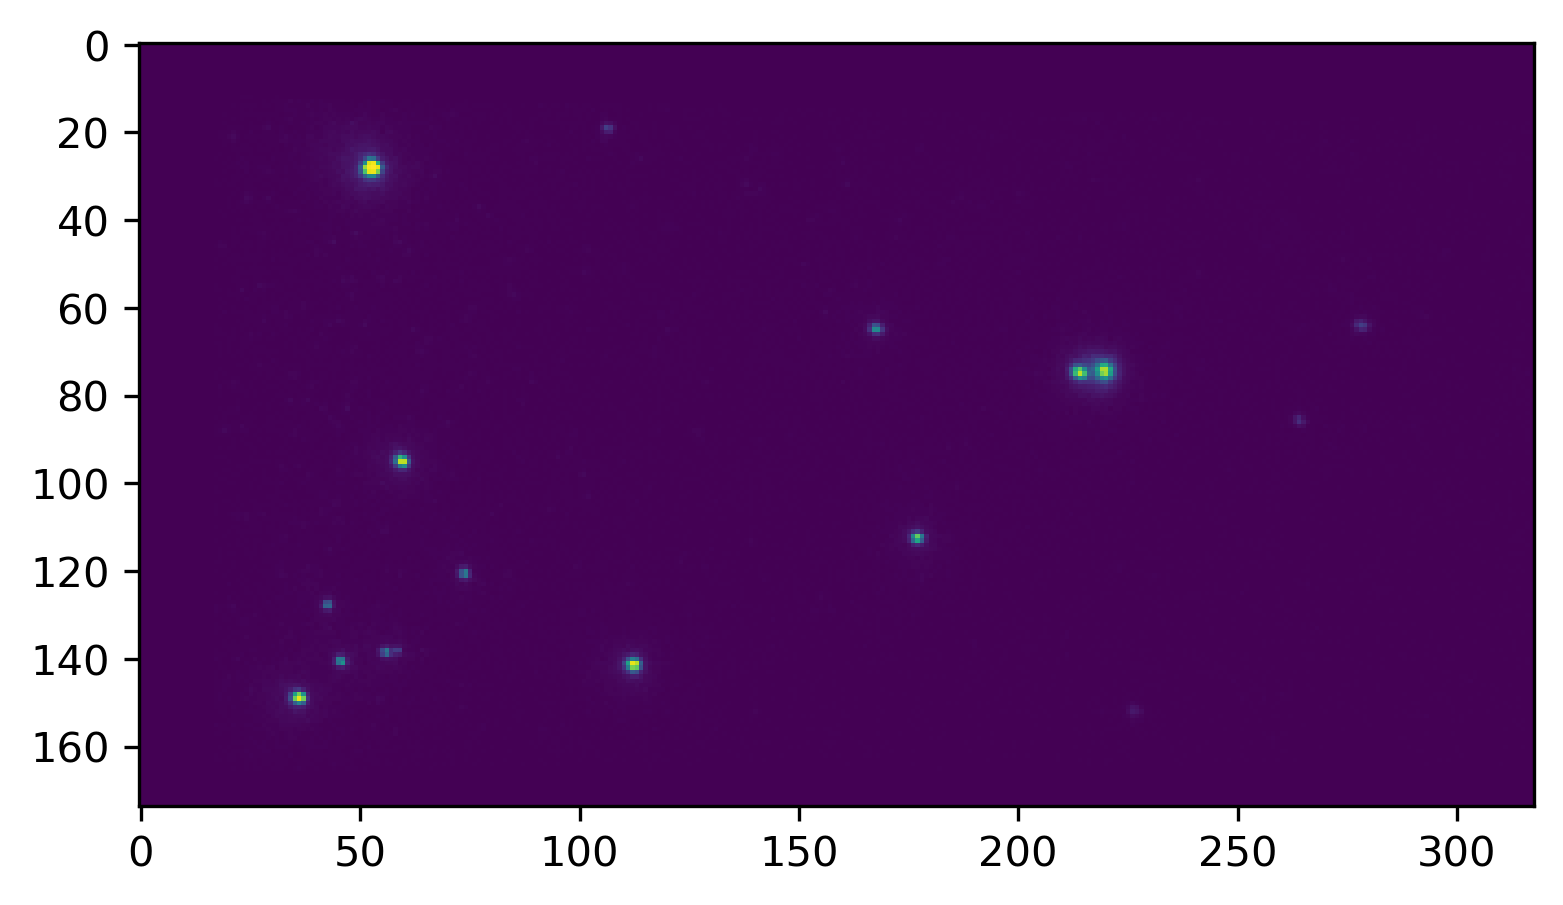

In [170]:
# Testing the transformation
shp = np.zeros([1,2])
shp[0,:] = img_beads_sm.shape
print(tr(shp))
shape1 = np.absolute(tr(shp)).astype(int)
img_test = transform.warp(img_beads_sm, tr_inv,output_shape = shape1.tolist()[0])
fig, ax = plt.subplots()
ax.imshow(img_test)

## Plotting simple linear transformed beads and beads from seq image
Then we will use them to do the RANSAC test and get the reliable pairs

In [ ]:
# x_range = 1566
# y_range = 3240
print(rough_tf(movie_centers))
print(seq_centers)
# plotting_res(
#     (x_range, y_range),
#     res=rough_tf(movie_centers),
#     pts_radius=3,
#     save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/movie_center.png",
# )
# plotting_res(
#     (x_range, y_range),
#     res=seq_centers,
#     pts_radius=3,
#     save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/seq_center.png",
# )


#### Doing the combination of two channels, to get all the peak locations from both channels.

In [1]:


#Instead of calculating the bead mapping we can load the transformation generated with channel_map


tr_G2R = transform.PolynomialTransform()
file_path = filedialog.askopenfilename(title = "Choose the forward transform file", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")
tr_G2R.params = np.load(file_path)
tr_R2G = transform.PolynomialTransform()
file_path = filedialog.askopenfilename(title = "Choose the inverse transform file", initialdir = os.path.dirname(file_path))
tr_R2G.params = np.load(file_path)

path_smFRET = filedialog.askopenfilename(title = "Choose the smFRET movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")
# path_smFRET = filedialog.askdirectory(title = "Choose the smFRET movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")

img_smFRET = io.imread(path_smFRET)
img1 = np.mean(img[0:10,::], axis = 0)
img1 = img1.astype("ushort")
rbrad = 10
#print(img1[10:20,10:20])
#img = np.zeros([20,20])
#img[10,5] = 1000
fig, ax = plt.subplots()
ax.imshow(img1[256:,:])
red = img1[256:,:]
green = img1[:256,:]
red = red - si.restoration.rolling_ball(red, radius=rb_rad)
green = green - si.restoration.rolling_ball(green, radius=rb_rad)
green = transform.warp(green,trR2G)
combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling

blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=.01)
CM = []
r = 3
[h,w] = red.shape
n_frames = img_smFRET.shape[0]
weights = np.zeros([len(CM),2*r+1,2*r+1])
traces_red = traces_green = np.zeros([len(CM),n_frames])

for i, blob in enumerate(blobs_log):
    x, y, d = blob
    if x>r and x<(h-r) and y>r and y<(w-r):
        temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
        CM.append(np.add(temp, [x-r,y-r]))
        
        c = plt.Circle(np.flip(CM[-1]), 3, color="red", linewidth=1, fill=False)
        ax.add_patch(c)
        
combined_peaks = CM


        
#print(img.shape)

#green_channel_centers = blob_detection(
#    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/grenn_channel_beads.tif",
#    min_sigma=1,
#    max_sigma=8,
#    threshold=0.0001,
#)

#red_channel_centers = blob_detection(
#    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/red_channel_beads.tif",
#    min_sigma=1,
#    max_sigma=8,
#    threshold=0.0001,
#)

# show_blob_detection_res('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/grenn_channel_beads.tif')
# show_blob_detection_res('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/red_channel_beads.tif')

#res, idx = count_nearest_pts(green_channel_centers, red_channel_centers, 2)
# print(idx)
# print(res)

#usable_green_beads = green_channel_centers[idx[np.where(res != inf)]]
#usable_red_beads = red_channel_centers[np.where(res != inf)]
#print(usable_green_beads)
#print(usable_red_beads)

#tform = transform.AffineTransform()
#tform.estimate(usable_green_beads, usable_red_beads)
#tsformed_green_beads = tform(usable_green_beads)
#print(tsformed_green_beads)
#plotting_res(
#    (256, 512),
#    res=usable_red_beads,
#    pts_radius=2,
#    save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/red_beads.png",
#)
# plotting_res(
#    (256, 512),
#    res=tsformed_green_beads,
#    pts_radius=2,
#    save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/tform_green_beads.png",
# )


NameError: name 'count_nearest_pts' is not defined

#### Getting the local maximum from ImageJ, for both channels
And then apply the affine transformation found in the last cell.

#### For the final result.

In [101]:
# Offset of the sequencing image region needs to be known
offy = 2329
offx = 2042
sizex, sizey = img_beads_seq.shape

# Dimensions of the sequencing image
x_lib_max = 2944
y_lib_max = 2866

def get_seq_coordinates(fastq_path, with_seq, tile):
    x_coordinate = []
    y_coordinate = []
    sequnces = []
#     max_x = 0
#     max_y = 0
#     min_x = 9e7
#     min_y = 9e7
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
#             if x_pos > max_x:
#                 max_x = x_pos
#             if x_pos < min_x:
#                 min_x = x_pos
#             if y_pos > max_y:
#                 max_y = y_pos
#             if y_pos < min_y:
#                 min_y = y_pos
            seq = str(record.seq)
            if tile_num == tile:
                if with_seq in seq:
                    x_coordinate.append(x_pos/10)
                    y_coordinate.append(y_pos/10)
                    sequences.append(seq)
#     print('Coordinates are found.')
    return x_coordinate, y_coordinate, sequences

path_FASTQ = filedialog.askopenfilename(title = "Choose the smFRET bead movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/20220826 M06455_0140_000000000-DGG7D")
x_lib, y_lib, seq = get_seq_coordinates(path_FASTQ, 'GGTCTCGTCCAATCTAT', 1)

# Rotate 90 deg right and flip vertically: x_new = -y, y_new = -x
x_lib1 = y_lib_max-y_lib
x_lib_max1 = y_lib_max
y_lib1 = x_lib_max - x_lib
y_lib_max1 = x_lib_max

x_lib1 = np.array(x_lib1)
y_lib1 = np.array(y_lib1)
# Cropping the cluster positions to match the region of the sequencing image
idx3 = np.where((x_lib1>offx)&&(x_lib1<(offx+sizex)&&(y_lib1>offy)&&(y_lib1<(offy+sizey)))

x_lib2 = np.subtract(x_lib1[idx3],offx)
y_lib2 = np.subtract(y_lib1[idx3],offy)

seq2 = [seq[i] for i in idx3]

peaks_sm = combiened_peaks
peaks_seq = np.concatenate(x_lib2,y_lib2, axis = 1)

peaks_sm_tr = tr(np.array(peaks_sm))

res1, idx1 = count_nearest_pts(peaks_sm_tr, peaks_seq, 2)
movie_centers2 = peaks_sm[idx[np.where(res1 != inf)]]
seq_centers2 = peaks_seq[np.where(res1 != inf)]
                
order = 3
kx,ky = Polywarp.polywarp(seq_centers2[:,0],seq_centers2[:,1],movie_centers2[:,0],movie_centers2[:,1],degree=order)
print(kx)
print(ky)
tr1 = transform.PolynomialTransform()
#tr.estimate(src,dst,order = 2)

order1 = 2*order
pidx = 0
par = np.zeros([2,int((order1+1)*(order1+2)/2)])
for j in range(order1 + 1):
    for i in range(j + 1):
        if (j-i)<=order and i<=order:
            par[0, pidx] = kx[j - i,i]
            par[1, pidx] = ky[j - i,i]
        else:
            par[0, pidx] = 0
            par[1, pidx] = 0
        pidx += 1
tr1.params = par        

kx,ky = Polywarp.polywarp(movie_centers2[:,0],movie_centers2[:,1],seq_centers2[:,0],seq_centers2[:,1],degree=order)
tr_inv1 = transform.PolynomialTransform()
#tr.estimate(src,dst,order = 2)

order1 = 2*order
pidx = 0
par = np.zeros([2,int((order1+1)*(order1+2)/2)])
for j in range(order1 + 1):
    for i in range(j + 1):
        if (j-i)<=order and i<=order:
            par[0, pidx] = kx[j - i,i]
            par[1, pidx] = ky[j - i,i]
        else:
            par[0, pidx] = 0
            par[1, pidx] = 0
        pidx += 1
tr_inv1.params = par    
               
res2, idx2 = count_nearest_pts(peaks_seq, tr1(peaks_sm),  2)
                
idx4 = np.where(res2 != inf)
idx5 = idx2[idx4]
xlib2_pairs = xlib2[idx4]
ylib2_pairs = ylib2[idx4]
seq2_pairs = [seq2[i] for i in idx4]
CM = peaks_sm[idx5]

                
# # save_path = "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/"
# # canvas_size = (1566, 3240)
# plotting_res(canvas_size, res, 3, save_path + "transformed_res.png")
# fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
# res_1, idx_1 = count_nearest_pts(res, fastq, 20)
# polished_movie = res[idx_1[np.where(res_1 != inf)]]
# polished_fastq = fastq[np.where(res_1 != inf)]
# print(len(polished_fastq))
# plotting_res((x_range, y_range), polished_fastq, 10, save_path=save_path + "fastq.png", gaussian_sigma=10)
# plotting_res((x_range, y_range), polished_movie, 3, save_path=save_path + "fret.png")


NameError: name 'SeqIO' is not defined

In [171]:
print(tr.params)

[[ 1.72230755e+01  5.90230332e-01 -4.06449470e-03  0.00000000e+00
   5.92463306e-05  0.00000000e+00]
 [ 1.18502738e+01  1.16726694e-02  6.06216073e-01  0.00000000e+00
  -5.13272645e-05  0.00000000e+00]]


In [ ]:
# Extracting the traces from matched smFRET peaks
# Select matching peaks from peak_locations and their sequences

for j,coord in enumerate(CM):
    x, y = coord
    x0 = int(x-r)
    x1 = int(x+r+1)
    y0 = int(y-r)
    y1 = int(y+r+1)
    dx = x-x0
    dy = y-y0
    
    it = np.nditer(weights[j], flags=['multi_index'], op_flags=['readwrite'])
    for w1 in it:
        xt,yt = it.multi_index
        w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
    it.close()

for i in range(n_frames):
    red1 = img[i,256:,:]
    red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
    green1 = img[i,:256,:]
    green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)
    
    for j,coord in enumerate(CM):
        x, y = coord
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0
        red2 = red1[x0:x1,y0:y1]
        green2 = green1[x0:x1,y0:y1]
        traces_red[j,i] = np.sum(np.multiply(w[j],red2))
        traces_green[j,i] = np.sum(np.multiply(w[j],green2))
        
        
# Save traces and sequences
frame_rate = 5
from scipy.io import savemat
mdict = {
    "time": np.divide(range(n_frames),frame_rate)
    "Cy3": traces_red,
    "Cy5": traces_green,
    "Seq": seq2_pairs
}
savemat(path_smFRET[:-4]+"_traces.mat" , mdict)

In [94]:
t = np.divide(range(10),10)
print(t)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


#### This part is for random checking.
10 random datasets are generated and stored in $rd\_set$.

In [ ]:
rd_set = []
for i in range(0, 1):
    rd = np.random.random((1300, 2))
    rd[:, 0] = rd[:, 0] * 512
    rd[:, 1] = rd[:, 1] * 256
    rd_set.append(rd)

rd_arr = []
arti_arr = []
phix_arr = []

peak_locations = combiened_peaks

res = model(np.array(peak_locations))
rd_res = model(np.array(rd_set[0]))
canvas_size = (1566, 3240)
plotting_res(canvas_size, rd_res, 3, save_path + "rd1.png")

save_path = "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/"
# plotting_res(canvas_size, res, 3, save_path + "transformed_res.png")
fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
phix = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_phix.csv")

for i in range(0, 100):
    res_rd, idx_rd = count_nearest_pts(rd_res, fastq, i)
    polished_fretPts_k = rd_res[idx_rd[np.where(res_rd != inf)]]
    polished_rd_k = fastq[np.where(res_rd != inf)]
    rd_arr.append(len(polished_rd_k))

for i in range(0, 100):
    res_final, idx_final = count_nearest_pts(res, fastq, i)
    polished_fretPts_final = res[idx_final[np.where(res_final != inf)]]
    polished_fastq_final = fastq[np.where(res_final != inf)]
    arti_arr.append(len(polished_fastq_final))

for i in range(0, 100):
    res_phix, idx_phix = count_nearest_pts(res, phix, i)
    polished_fretPts_phix = res[idx_phix[np.where(res_phix != inf)]]
    polished_fastq_phix = phix[np.where(res_phix != inf)]
    phix_arr.append(len(polished_fastq_phix))

plt.figure()
plt.plot(rd_arr, label='random')
plt.plot(arti_arr, label='lib')
plt.plot(phix_arr, label='phix')
plt.plot(np.array(arti_arr) - np.array(rd_arr), label='Difference')
plt.legend()
plt.show()
# plotting_res((x_range, y_range), polished_rd_k, 3, save_path + "polished_rd.png")
# plotting_res(
#     (x_range, y_range), polished_fretPts_k, 3, save_path + "polished_fretPts_rd.png"
# )
